In [1]:
import os
import time
import warnings
import pandas as pd
import numpy as np
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=100)
sc.settings.set_figure_params(dpi_save=300)
sc.logging.print_version_and_date()

Running Scanpy 1.6.0, on 2021-06-11 15:58.


In [2]:
#首先将每个批次数据切分开，总共有2个批次
adata = sc.read_h5ad('/media/bgi/zoubin/single_cell/batch_correction/data/dataset5.h5ad')

adata = adata[(adata.obs.batch != '0') | (adata.obs.celltype != 'B cell')]
adata = adata[(adata.obs.batch != '1') | (adata.obs.celltype != 'NK cell')]
adata = adata[(adata.obs.batch != '1') | (adata.obs.celltype != 'Monocyte_CD14')]
adata = adata[(adata.obs.batch != '0') | (adata.obs.celltype != 'CD8 T cell')]

adata0 = adata[adata.obs.batch=='0']
adata1 = adata[adata.obs.batch=='1']

In [7]:
#adata0 processed
sc.pp.normalize_per_cell(adata0, counts_per_cell_after=1e4)
sc.pp.log1p(adata0)
sc.pp.scale(adata0)
sc.tl.pca(adata0, svd_solver='arpack')

#adata1 processed
sc.pp.normalize_per_cell(adata1, counts_per_cell_after=1e4)
sc.pp.log1p(adata1)
sc.pp.scale(adata1)
sc.tl.pca(adata1, svd_solver='arpack')

normalizing by total count per cell
Trying to set attribute `.obs` of view, copying.
    finished (0:00:01): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
computing PCA
    with n_comps=50
    finished (0:00:15)
normalizing by total count per cell
Trying to set attribute `.obs` of view, copying.
    finished (0:00:01): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
computing PCA
    with n_comps=50
    finished (0:00:12)


In [8]:
#生成MMD算法输入的文件，2个只包含表达矩阵的csv
data0 = pd.DataFrame(adata0.obsm['X_pca'])
data1 = pd.DataFrame(adata1.obsm['X_pca'])

data0.to_csv('Figure4_dataset5_0.csv',index=None,header=None)
data1.to_csv('Figure4_dataset5_1.csv',index=None,header=None)

In [2]:
!python train.py

Epoch 1, loss: 0.246, counter: 0
Learning rate = 0.0000100
Epoch 2, loss: 0.248, counter: 1
Learning rate = 0.0000100
Epoch 3, loss: 0.246, counter: 2
Learning rate = 0.0000100
Epoch 4, loss: 0.247, counter: 3
Learning rate = 0.0000100
Epoch 5, loss: 0.247, counter: 4
Learning rate = 0.0000100
Epoch 6, loss: 0.247, counter: 5
Learning rate = 0.0000100
Finished training
Figure(800x800)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
Figure(800x800)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [2]:
data0 = np.load("sample1.csv.npy")
data1 = np.load("calibrated_sample2.csv.npy")

In [3]:
#将矫正后数据保存会adata
adata = sc.read_h5ad('/media/bgi/zoubin/single_cell/batch_correction/data/dataset5.h5ad')

adata = adata[(adata.obs.batch != '0') | (adata.obs.celltype != 'B cell')]
adata = adata[(adata.obs.batch != '1') | (adata.obs.celltype != 'NK cell')]
adata = adata[(adata.obs.batch != '1') | (adata.obs.celltype != 'Monocyte_CD14')]
adata = adata[(adata.obs.batch != '0') | (adata.obs.celltype != 'CD8 T cell')]

adata0 = adata[adata.obs.batch=='0']
adata1 = adata[adata.obs.batch=='1']
adata0.obsm['X_pca'] = data0
adata1.obsm['X_pca'] = data1
adata_MMD = adata0.concatenate(adata1,index_unique=None,batch_categories=['10X 3\'','10X 5\''])

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:01:11)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:37)
... storing 'celltype' as categorical


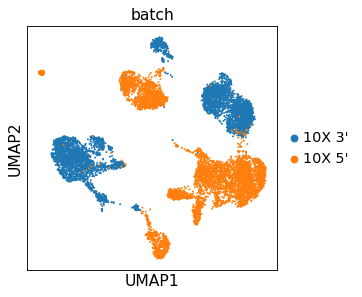

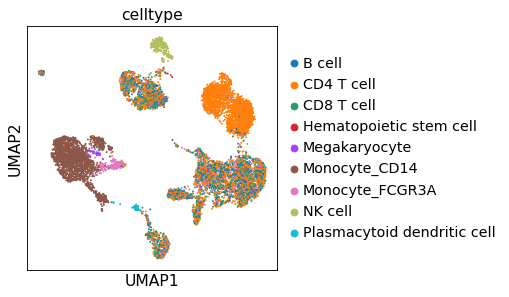

In [8]:
#plot result
sc.pp.neighbors(adata_MMD)
sc.tl.umap(adata_MMD)

sc.pl.umap(adata_MMD,color=['batch'],save='_figure4_MMD_batch.pdf')
sc.pl.umap(adata_MMD,color=['celltype'],save='_figure4_MMD_celltype.pdf')

In [9]:
from math import log
from sklearn.metrics import silhouette_score

def shannon_entropy (x, b_vec, N_b):
    
    tabled_values = b_vec[x > 0].value_counts()/ len(b_vec[x >0]) #class 'pandas.core.series.Series'

    tabled_val = tabled_values.tolist() 
    
    entropy = 0.0
    for element in tabled_val:
        if element != 0:
            entropy += element * log(element)
            
    entropy /= log(N_b)

    return(-entropy) #the entropy formula is the -sum, this is why we include the minus sign

def compute_entropy(adata, output_entropy=None, batch_key='batch', celltype_key='celltype'):
    print("Calculating entropy ...")
    kwargs = {}
    #batch vector(batch id of each cell)
    kwargs['batch_vector'] = adata.obs[batch_key]
    #modify index of batch vector so it coincides with matrix's index
    kwargs['batch_vector'].index = range(0,len(kwargs['batch_vector']))
    #number of batches
    kwargs['N_batches'] = len(adata.obs[batch_key].astype('category').cat.categories)

    #cell_type vector( betch id of each cell)
    kwargs['cell_type_vector'] = adata.obs[celltype_key]
    #modify index of cell_type vector so it coincides with matrix's index
    kwargs['cell_type_vector'].index = range(0,len(kwargs['cell_type_vector']))
    #number of cell_types
    kwargs['N_cell_types'] = len(adata.obs[celltype_key].astype('category').cat.categories)    

    try:
        knn_graph = adata.uns['neighbors']
        print('use exist neighbors')
    except KeyError:
        #compute neighbors
        print('compute neighbors')
        sc.tl.pca(adata)
        sc.pp.neighbors(adata)

    #knn graph
    knn_graph = adata.uns['neighbors']['connectivities']
    #transforming csr_matrix to dataframe
    df = pd.DataFrame(knn_graph.toarray())
    
    #apply function
    batch_entropy = df.apply(shannon_entropy, axis=0, args=(kwargs['batch_vector'],kwargs['N_batches']))
    cell_type_entropy = df.apply(shannon_entropy, axis=0, args=(kwargs['cell_type_vector'] ,kwargs['N_cell_types']))
    print("Entropy calculated!")
    
    results = {'batch': batch_entropy, "cell_type":cell_type_entropy}
    results = pd.concat(results, axis = 1, keys = ['batch', 'cell_type'])
    
    if output_entropy:
        results.to_csv(output_entropy, header = True, index = False)
    
    return results

def silhouette_coeff_ASW(adata, method_use='raw',save_dir='', save_fn='', percent_extract=0.8, batch_key='batch', celltype_key='celltype'):
    asw_fscore = []
    asw_bn = []
    asw_bn_sub = []
    asw_ctn = []
    iters = []
    for i in range(20):
        iters.append('iteration_'+str(i+1))
        rand_cidx = np.random.choice(adata.obs_names, size=int(len(adata.obs_names) * percent_extract), replace=False)
        adata_ext = adata[rand_cidx,:]
        asw_batch = silhouette_score(adata_ext.obsm['X_pca'], adata_ext.obs[batch_key])
        asw_celltype = silhouette_score(adata_ext.obsm['X_pca'], adata_ext.obs[celltype_key])
        min_val = -1
        max_val = 1
        asw_batch_norm = (asw_batch - min_val) / (max_val - min_val)
        asw_celltype_norm = (asw_celltype - min_val) / (max_val - min_val)
        
        fscoreASW = (2 * (1 - asw_batch_norm)*(asw_celltype_norm))/(1 - asw_batch_norm + asw_celltype_norm)
        asw_fscore.append(fscoreASW)
        asw_bn.append(asw_batch_norm)
        asw_bn_sub.append(1-asw_batch_norm)
        asw_ctn.append(asw_celltype_norm)
    

    df = pd.DataFrame({'asw_batch_norm':asw_bn, 'asw_batch_norm_sub': asw_bn_sub,
                       'asw_celltype_norm': asw_ctn, 'fscore':asw_fscore,
                       'method_use':np.repeat(method_use, len(asw_fscore))})
#     df.to_csv(save_dir + save_fn + '.csv')
#     print('Save output of pca in: ',save_dir)
    return df

In [ ]:
asw_MMD = silhouette_coeff_ASW(adata_MMD)
entropy_MMD = compute_entropy(adata_MMD)
asw_MMD.to_csv('Figure4_asw_MMD.csv',index=0)
entropy_MMD.to_csv('Figure4_entropy_MMD.csv',index=0)